In [79]:
summary_models = []

In [80]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

df_path = 'data/checkpoint_2_table.csv'

df = pd.read_csv(df_path)

df.loc[:, 'meaneduc'] = df.loc[:, 'meaneduc'].fillna(0)

In [82]:
# Fix 'yes' and 'no' in variables
need_improve = ['edjefe', 'edjefa', 'dependency']
for col in need_improve:
 df.loc[df.loc[:, col] == "no", col] = '0'
 df.loc[df.loc[:, col] == "yes", col] = '1'
 if col == 'dependency':
     df.loc[:, col] = df.loc[:, col].astype(float)
 df.loc[:, col] = df.loc[:, col].astype(int)

In [83]:
selected_vars = ['edjefe', 'edjefa', 'meaneduc', 'dependency', 'epared2', 'epared3',
            'etecho2', 'etecho3', 'eviv2', 'eviv3', 'hhsize', 'hacapo', 'v14a', 
            'refrig', 'v18q', 'hacdor', 'area1', 'computer', 'television', 
            'mobilephone', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6', 'wall_quality', 
            'ceiling_quality', 'floor_quality', 'lack_basic_needs', 
            'phones-per-capita', 'rooms-per-capita', 'electricity_quality', 
            'resid_management', 'Toilet_quality', 'cooking_energy', 
            'electronics_idx', 'central_urban', 'choro_pc_rural', 
            'choro_pc_urban', 'choro_pc_povre', 'adul_hhsize', 'total_hhsize', 
            'dis_count', 'male_count', 'female_count', 'age_less10_count', 
            'free_or_coupled_count', 'married_count', 'divorced_count', 
            'separated_count', 'widow_count', 'single_count', 'partner_count', 
            'child_count', 'step_child_count', 'child_inlaw_count', 
            'grandson_daughter_count', 'parent_count', 'parent_inlaw_count', 
            'sibling_count', 'brosis_inlaw_count', 'otherfam_count', 'nonfam_count', 'Target']
len(selected_vars) 

64

In [84]:
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler

scaler = MinMaxScaler()
X = scaler.fit_transform(df.loc[:, selected_vars[0:63]])
y = df.loc[:, 'Target']


X_train, X_test_normalized, y_train_, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=2938)


over_sampler = RandomOverSampler(random_state=42)
X_train_normalized, y_train = over_sampler.fit_resample(X_train, y_train_)

# ALL FEATURES

### KNN Classification

In [85]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Train the KNN classifier
k =9
clf = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
clf.fit(X_train_normalized, y_train)

# Test the KNN classifier
y_pred = clf.predict(X_test_normalized)

# Evaluate the performance of the model
train_acc1 = clf.score(X_train_normalized, y_train)
test_acc1 = f1_score(y_test, y_pred, average='macro')
train_acc1
test_acc1
summary_models.append({"Feature Type Approach" : "All", "Model" : "KNN", "Train Accuracy": train_acc1 , "Test Accuracy": test_acc1})

### Random Forest Classification

In [86]:
forest1 = RandomForestClassifier(n_estimators = 4, criterion = 'gini',
                                max_depth = 4, min_samples_split = 3, 
                                min_samples_leaf = 1, max_features = 15,
                                bootstrap = True, random_state = 1252, 
                                max_samples = X_train.shape[0])
forest1.fit(X_train_normalized, y_train)

# Train prediction
y1_pred = forest1.predict(X_train_normalized)
f1_score_train = f1_score(y_train, y1_pred, average='macro')

# Test prediction
y1_pred = forest1.predict(X_test_normalized)
f1_score_test = f1_score(y_test, y1_pred, average='macro')

f1_score_train
f1_score_test

summary_models.append({"Feature Type Approach" : "All", "Model" : "Random Forest", "Train Accuracy": f1_score_train, "Test Accuracy": f1_score_test})

# 1. Features from Recursive Feature Elimination

In [87]:
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

rfe_model = DecisionTreeClassifier()

# Use cross-validation to determine the optimal number of features to keep
rfecv = RFECV(estimator=rfe_model, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X_train_normalized, y_train)

# Print the ranking of features
rfe_ind = rfecv.ranking_ - 1

feat_rank = dict(zip(selected_vars[0:63], rfecv.ranking_))

# Sort the dictionary by ranking values
top_feat = sorted(feat_rank.items(), key=lambda x: x[1])

# Print the top n features and their ranking
n_features = []
for feat in top_feat:
    n_features.append(feat[0])

X_rfe = df.loc[:, n_features]
y_rfe = df.loc[:, 'Target']
X_rfe.loc[:, 'meaneduc'] = X_rfe.loc[:, 'meaneduc'].fillna(0)
X_rfe_train_normalized = scaler.fit_transform(X_rfe)
# Split to train and test
X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(X_rfe_train_normalized, y_rfe, test_size=0.2, 
                                                    random_state=2938)

### Gradient Boosting Classifier

In [88]:
from sklearn.ensemble import GradientBoostingClassifier
gradient_tree = GradientBoostingClassifier(max_depth = 7,
                                      n_estimators = 41, 
                                      learning_rate = .26,
                                      min_samples_split = 3, 
                                      min_samples_leaf = 2,
                                      random_state = 8590)

gradient_tree.fit(X_train_rfe[:, 0:11], y_train_rfe)
# Train prediction
y_pred2 = gradient_tree.predict(X_train_rfe[:, 0:11])
f1_score_train_bg = f1_score(y_train_rfe, y_pred2, average='macro')

# Test prediction
y_pred2t = gradient_tree.predict(X_test_rfe[:, 0:11])
f1_score_test_bg = f1_score(y_test_rfe, y_pred2t, average='macro')

f1_score_train_bg
f1_score_test_bg

summary_models.append({"Feature Type Approach" : "Recursive Elimination", "Model" : "Gradient Boost", "Train Accuracy": f1_score_train_bg, "Test Accuracy": f1_score_test_bg})

In [89]:
forest2 = RandomForestClassifier(n_estimators = 5, criterion = 'gini',
                                max_depth = 16, min_samples_split = 3, 
                                min_samples_leaf = 1, max_features = 11,
                                bootstrap = True, random_state = 1252, 
                                max_samples = X_train_rfe.shape[0])
forest2.fit(X_train_rfe[:, 0:12], y_train_rfe)

# Train prediction
y_pred_rf2 = forest2.predict(X_train_rfe[:, 0:12])
f1_score_train_rf = f1_score(y_train_rfe, y_pred_rf2, average='macro')

# Test prediction
y_pred_rf2 = forest2.predict(X_test_rfe[:, 0:12])
f1_score_test_rf = f1_score(y_test_rfe, y_pred_rf2, average='macro')

f1_score_train_rf
f1_score_test_rf

summary_models.append({"Feature Type Approach" : "Recursive Elimination", "Model" : "Random Forest", "Train Accuracy": f1_score_train_rf, "Test Accuracy": f1_score_test_rf})

In [90]:
### Logistic Regression
logis = LogisticRegression(penalty = 'l2', multi_class = 'auto', max_iter = 1000)
logis.fit(X_train_rfe[:, 0:35], y_train_rfe)

# Train prediction
y_pred_lr = logis.predict(X_train_rfe[:, 0:35])
f1_score_train_lr = f1_score(y_train_rfe, y_pred_lr, average='macro')

# Test prediction
y_pred_lrt = logis.predict(X_test_rfe[:, 0:35])
f1_score_test_lr = f1_score(y_test_rfe, y_pred_lrt, average='macro')

f1_score_train_lr
f1_score_test_lr

summary_models.append({"Feature Type Approach" : "Recursive Elimination", "Model" : "Logistic Regression", "Train Accuracy": f1_score_train_lr, "Test Accuracy": f1_score_test_lr})

In [91]:

# Train the KNN classifier
k = 17
clf1 = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
clf1.fit(X_train_rfe[:, 0:49], y_train_rfe)

# Test the KNN classifier
y_pred = clf1.predict(X_test_rfe[:, 0:49])

# Evaluate the performance
train_acc2 = clf1.score(X_train_rfe[:, 0:49], y_train_rfe)
test_acc2 = f1_score(y_test_rfe, y_pred, average='macro')
train_acc2
test_acc2

summary_models.append({"Feature Type Approach" : "Recursive Elimination", "Model" : "KNN", "Train Accuracy": train_acc2, "Test Accuracy": test_acc2})

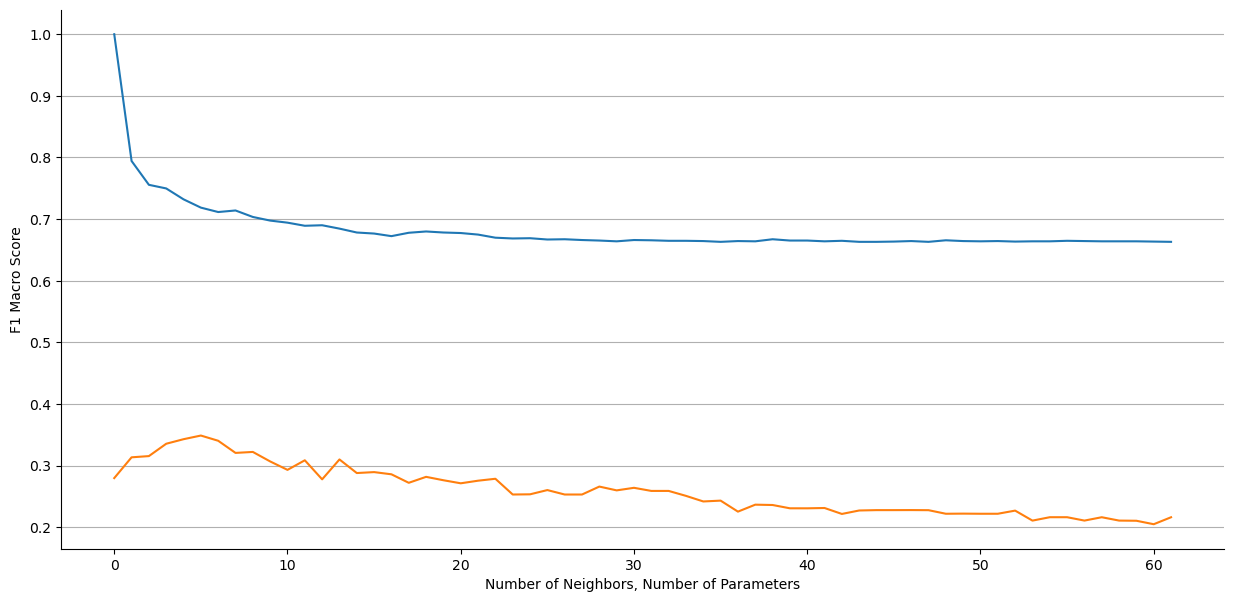

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [92]:
list_scores_train = []
list_scores_test = []

h = 49
for n in range(1, 63):
        clf1 = KNeighborsClassifier(n_neighbors=n, metric='manhattan')
        clf1.fit(X_train_rfe[:, 0:h], y_train_rfe)

        y_pred = clf1.predict(X_test_rfe[:, 0:h])
        train_acc2 = clf1.score(X_train_rfe[:, 0:h], y_train_rfe)
        test_acc2 = f1_score(y_test_rfe, y_pred, average='macro')
        list_scores_train.append(train_acc2)
        list_scores_test.append(test_acc2)
    
fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(list_scores_train)
plt.plot(list_scores_test)
plt.xlabel('Number of Neighbors, Number of Parameters')
plt.ylabel('F1 Macro Score')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y')
plt.show()
ax.legend()

# 2. Lasso Feature Selection

In [93]:
from sklearn.linear_model import Lasso
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler

df_lf = pd.get_dummies(df, columns=df.select_dtypes(include='object').columns)

X_lf = df_lf.loc[:, selected_vars[0:63]]
y_lf = df_lf.loc[:, 'Target']

# Split to train and test
X_train_lf, X_test_lf, y_train_lf, y_test_lf = train_test_split(X_lf, y_lf, test_size=0.2, 
                                                    random_state=2938)

# Normalize the features in the training and testing datasets
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train_lf)
X_test_normalized = scaler.transform(X_test_lf)

# Create a Lasso object
lasso = Lasso(alpha=0.1)

# Fit the Lasso model to the data
lasso.fit(X_train_lf, y_train_lf)

lasso_features = []
for feature, coef in zip(X_train_lf.columns, lasso.coef_):
    if coef > 0:
        lasso_features.append(feature)
    
X_lf_fin = df.loc[:, lasso_features]
y_lf_fin = df.loc[:, 'Target']
X_lf_fin.loc[:, 'meaneduc'] = X_lf_fin.loc[:, 'meaneduc'].fillna(0)
X_lf_train_normalized = scaler.fit_transform(X_lf_fin)
# Split to train and test
X_train_lf, X_test_lf, y_train_lf, y_test_lf = train_test_split(X_lf_train_normalized, y_lf_fin, test_size=0.2, 
                                                    random_state=2938)
lasso_features[0:6]

['edjefe',
 'edjefa',
 'meaneduc',
 'wall_quality',
 'floor_quality',
 'electronics_idx']

### GradientBoostingClassifier

In [94]:
from sklearn.ensemble import GradientBoostingClassifier
gradient_tree_lf = GradientBoostingClassifier(max_depth = 10,
                                      n_estimators = 63, 
                                      learning_rate = .20,
                                      min_samples_split = 3, 
                                      min_samples_leaf = 2,
                                      random_state = 8590)

gradient_tree_lf.fit(X_train_lf[:, 0:6], y_train_lf)
# Train prediction
y_pred_lf= gradient_tree_lf.predict(X_train_lf[:, 0:6])
f1_scoretrain_lf_gb = f1_score(y_train_lf, y_pred_lf, average='macro')
f1_scoretrain_lf_gb

# Test prediction
y_pred_lft = gradient_tree_lf.predict(X_test_lf[:, 0:6])
f1_scoretest_lf_gb = f1_score(y_test_lf, y_pred_lft, average='macro')
f1_scoretest_lf_gb

summary_models.append({"Feature Type Approach" : "Lasso", "Model" : "Gradient Boost", "Train Accuracy": f1_scoretrain_lf_gb, "Test Accuracy": f1_scoretest_lf_gb})

### RandomForestClassifier

In [95]:
forest_lf = RandomForestClassifier(n_estimators = 7, criterion = 'gini',
                                max_depth = 20, min_samples_split = 3, 
                                min_samples_leaf = 1, max_features = 3,
                                bootstrap = True, random_state = 1252, 
                                max_samples = X_train_lf.shape[0])
forest_lf.fit(X_train_lf[:, 0:5], y_train_lf)

# Train prediction
y_pred_lf2 = forest_lf.predict(X_train_lf[:, 0:5])
f1_scoretrain_lf_rf = f1_score(y_train_lf, y_pred_lf2, average='macro')
f1_scoretrain_lf_rf
# Test prediction
y_pred_lf2t = forest_lf.predict(X_test_lf[:, 0:5])
f1_scoretest_lf_rf = f1_score(y_test_lf, y_pred_lf2t, average='macro')
f1_scoretest_lf_rf
summary_models.append({"Feature Type Approach" : "Lasso", "Model" : "Random Forest", "Train Accuracy": f1_scoretrain_lf_rf, "Test Accuracy": f1_scoretest_lf_rf})

### Logistic Regression

In [96]:
logis = LogisticRegression(penalty = 'l2', multi_class = 'auto', max_iter = 500)
logis.fit(X_train_lf[:, 0:10], y_train_lf)

# Train prediction
y_pred_lf3 = logis.predict(X_train_lf[:, 0:10])
f1_scoretrain_lf_lr = f1_score(y_train_lf, y_pred_lf3, average='macro')
f1_scoretrain_lf_lr
# Test prediction
y_pred_lf3t = logis.predict(X_test_lf[:, 0:10])
f1_scoretest_lf_lr= f1_score(y_test_lf, y_pred_lf3t, average='macro')
f1_scoretest_lf_lr
summary_models.append({"Feature Type Approach" : "Lasso", "Model" : "Logistic Regression", "Train Accuracy": f1_scoretrain_lf_lr, "Test Accuracy": f1_scoretest_lf_lr})

### KNN

In [97]:
k = 19
clf3 = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
clf3.fit(X_train_lf[:, 0:6], y_train_lf)

# Test the KNN classifier
y_pred_lf4 = clf3.predict(X_test_lf[:, 0:6])

# Evaluate the performance of the model
train_acc3 = clf3.score(X_train_lf[:, 0:6], y_train_lf)
test_acc3 = f1_score(y_test_lf, y_pred_lf4, average='macro')
train_acc3
test_acc3
summary_models.append({"Feature Type Approach" : "Lasso", "Model" : "KNN", "Train Accuracy": train_acc3, "Test Accuracy": test_acc3})

In [99]:
summary = pd.DataFrame.from_records(summary_models)
summary

,Feature Type Approach,Model,Train Accuracy,Test Accuracy
0,All,KNN,0.802724,0.315664
1,All,Random Forest,0.485140,0.396703
2,Recursive Elimination,Gradient Boost,0.908615,0.345798
3,Recursive Elimination,Random Forest,0.822045,0.326434
4,Recursive Elimination,Logistic Regression,0.363737,0.322520
5,Recursive Elimination,KNN,0.672414,0.286015
6,Lasso,Gradient Boost,0.800354,0.299238
7,Lasso,Random Forest,0.659176,0.285180
8,Lasso,Logistic Regression,0.261427,0.269358
9,Lasso,KNN,0.668629,0.305467
